# L1 - Sintetizando dados tabulares de saúde

O objetivo deste notebook é gerar um banco de dados sintéticos de resultados de exames de hemograma.

Os dados fornecidos são 2 planilhas com dados reais extraídos de uma base de resultados de exames de laboratório de análises clínicas.

Será gerada uma base de dados com 1000 resultados de exames fictícios.

A simplificação admitida é de gerar apenas 1 coluna ou entrada da tabela. Também é permitido aproximarmos a distribuição através de métodos paramétricos.

## Metodologia

Primeiramente foram unificadas as duas tabelas de dados em um único DataFrame. A coluna escolhida para sintetizar foi a IDADE de cada paciente.

Após ler os dados, podemos verifcar algumas informações da base de dados.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

np.random.seed(1111)

df1 = pd.read_csv("data1.csv")
df2 = pd.read_csv("data2.csv")

df_total = pd.concat([df1, df2], axis=0)

# Remove linhas com valores faltantes (NaN).
df_total.dropna(inplace=True)

# mostra algumas metricas da DB.
df_total.info()

input_data = df_total["age"].to_numpy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266878 entries, 0 to 152922
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   age     266878 non-null  int64 
 1   id      266878 non-null  int64 
 2   gender  266878 non-null  object
 3   exam    266878 non-null  object
 4   value   266878 non-null  object
dtypes: int64(2), object(3)
memory usage: 12.2+ MB


### Visualização

Para escolhermos uma distribuição paramétrica que se adeque aos dados, uma boa abordagem é visualizar a distribuição dos dados através de um histograma.

<AxesSubplot:xlabel='Idade'>

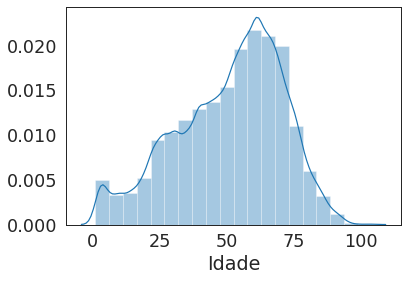

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
np.random.seed(1111)

sns.set_style('white')
sns.set_context("paper", font_scale=2)
sns.distplot(input_data, axlabel="Idade", bins=20)

### Escolha da distribuição probabilística

A visualização do histograma mostra certa semelhança na distribuiçao com a de uma curva gaussiana.

Sendo assim, iremos extrair os parâmetros estatísticos necessários para propormos este modelo paramétrico de geração de dados.

Os dados que almejamos obter são `desvio padrão` e `média` da distribuição original.

Média e Desvio Padrão da distribuição original (em anos): 
 51.018101904240886 e 19.840805923134305.


Média e Desvio Padrão da distribuição sintética (em anos): 
 51.115 e 19.30729849046728.


Distribuição dos dados sintéticos: 


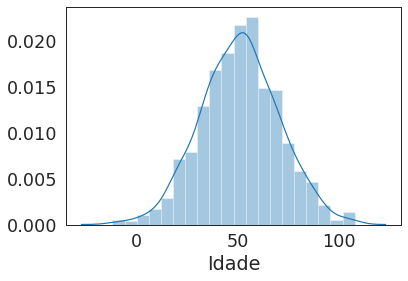

In [3]:
np.random.seed(1111)

desv_pad = input_data.std()
media = input_data.mean()

print("Média e Desvio Padrão da distribuição original (em anos): \n", media, "e",
      str(desv_pad) + ".\n\n")

pontos_sinteticos = np.random.normal(loc=media, scale=desv_pad, size=1000).astype('int')

# plt.title("Distribuição dos dados sintéticos")
sns.distplot(pontos_sinteticos, axlabel="Idade", bins=20)

desv_pad = pontos_sinteticos.std()
media = pontos_sinteticos.mean()
print("Média e Desvio Padrão da distribuição sintética (em anos): \n", media, "e",
      str(desv_pad) + ".\n\n")

print("Distribuição dos dados sintéticos: ")

## Resultados

A distribuição probabilística possui média e desvio padrão próximos dos valores encontrados nos dados originais, conforme exibe a célula anterior.

Abaixo, fazemos a geração dos dados sintétios completos, incluindo as demais colunas, que são amostradas aleatoriamente dos dados originais, e os dados da coluna de "idade", que são gerados sinteticamente através do _sampling_ da distribuição normal encontrada.

In [4]:
np.random.seed(1111)

df_sampling = df_total.sample(1000)

df_sampling["age"] = pontos_sinteticos

print(df_sampling.head(), "\n\n")
df_sampling.info()

df_sampling.to_csv("dados_sinteticos.csv", index=False)

       age        id gender                  exam   value
40074   25  24861660      M  NEUTRÓFILOS ABSOLUTO  4,5000
97390   29  24308481      M         NEUTRÓFILOS %    54,3
19095   66  25821798      M         NEUTRÓFILOS %    28,6
49605   33  23763342      M      PLAQUETAS SANGUE  189,00
41861   80  25501867      M      PLAQUETAS SANGUE     287 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 40074 to 41473
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     1000 non-null   int64 
 1   id      1000 non-null   int64 
 2   gender  1000 non-null   object
 3   exam    1000 non-null   object
 4   value   1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 46.9+ KB


### Acurácia

É difícil definir uma métrica de erro que determine se um dado por ser considerado sintético ou real, mas podemos avaliar quantos dados o modelo proposto gera e que não sejam, por coincidência, iguais aos originais.

Na célula a seguir, é mostrado que, das 1000 amostras geradas, 15 coincidiram com os dados originais, ou seja, por uma coincidência na amostragem de nosso modelo generativo, dados de pacientes "vazaram" na base de dados final.

Isto corresponde a uma acurácia de 985/1000 = 98,5%.

In [5]:
# Dados que foram gerados, por coincidencia, iguais aos originais
df_dados_vazados = pd.merge(df_sampling, df_total, how='inner', on=['age', 'id', 'gender', 'exam', 'value'])

print("Acurácia: ", (1000 - df_dados_vazados.shape[0]) * 100/ 1000, "%.")

Acurácia:  98.5 %.


## Discussão e Conclusão

O modelo paramétrico de distribuição escolhido foi a distribuição de probabilidade gaussiana ou normal. Este é um modelo relativamente simples, fazendo uso de apenas dois parâmetros: Desvio padrão e Média.
Qualquer distribuição de idade cuja média e desvio padrão se aproximem da original, é considerada realista para o modelo adotado.
Uma métrica de qualidade que podemos reportar é a acurácia, sendo definida comoo número de resultados gerados que não estavam na base original e exibida na célula anterior.

Como garantimos que a síntese de dados é realista? O atual modelo considera apenas a distribuição dos dados de idade, e nao faz sua correlação com as demais entradas.
Garantir que um dado se classifica como realista exigiria definir uma métrica que especifique qual dado é real ou sintético. O que podemos fazer é a construção de modelos cada vez mais elaborados e que considerem mais especificidades dos dados.

Por exemplo: É esperado que haja dependência entre as variáveis de entrada, formando grupos de pacientes que são mais propensos a determinados resultados nos diferentes tipos de exames. Um paciente mais velho, por exemplo, pode ter maior colesterol ou chance de infartar do que um paciente jovem. Esse tipo de análise é ignorada no modelo proposto.
Seria possível fazer incrementos futuros neste modelo com uma abordagem bayesiana, como gerar uma distribuição de dados de idade para cada uma das combinações possíveis das demais variáveis de entrada (verossimilhança).
Também seria possível adotar modelos que constroem uma representação mais flexível, como aqueles que fazem uso de Deep Learning.

Com este projeto foi possível destacar e refletir acerca dos detalhes e relações estatísticas que caracterizam um dado como real, o que seria útil caso decidíssemos progredir com o modelo de geração dados sintéticos.